In [20]:
#%matplotlib qt
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [23]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [24]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

In [25]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/velocity')

In [26]:
def phi(alpha, theta, mean=0, scale=1):
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return scipy.stats.norm.cdf(x, loc=mean, scale=scale)

In [29]:
def odd_phi(alpha, theta, mean=0, scale=1):
    return 0.5 * (phi(alpha, theta, mean=mean, scale=scale) - phi(-alpha, theta, mean=mean, scale=scale))

In [30]:
def phi_tilde(alpha, theta, mean=0, scale=1):
    # the odd part of phi is simply phi - 1/2 as for the step function
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return scipy.stats.norm.cdf(x, loc=mean, scale=scale) - 1/2

In [31]:
def psi(alpha, theta):
    # psi is symmetric, psi=scipy.stats.norm.pdf(-alpha * cotan(theta))
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return np.exp(-(x ** 2) / 2) / np.sqrt(2 * np.pi)

In [10]:
def q(alpha, theta, mean=0, scale=1, sign=True):
    if sign:
        eps_theta = np.sign(np.pi/2 - theta)
    else:
        eps_theta = 1
#    return eps * (np.sin(theta) * alpha * phi(alpha, theta, mean=mean, scale=scale) - 
#                  np.cos(theta) * psi(alpha, theta))
    return eps_theta * (np.sin(theta) * alpha * phi_tilde(alpha, theta, mean=mean, scale=scale) - 
                        np.cos(theta) * psi(alpha, theta))

In [32]:
def odd_q(alpha, theta, mean=0, scale=1, sign=True):
    if sign:
        eps_theta = np.sign(np.pi/2 - theta)
    else:
        eps_theta = 1
#    return eps * (np.sin(theta) * alpha * phi(alpha, theta, mean=mean, scale=scale) - 
#                  np.cos(theta) * psi(alpha, theta))
    return eps_theta * (np.sin(theta) * alpha * odd_phi(alpha, theta, mean=mean, scale=scale) - 
                        np.cos(theta) * psi(alpha, theta))

In [11]:
def q_tilde(alpha, theta, mean=0, scale=1, sign=True, d_H=1):
    return scipy.integrate.quad(
        lambda r: (r ** d_H) * q(r * alpha, theta, mean=mean, scale=scale, sign=sign) * \
                  np.exp(-(r ** 2)/2), a=0, b=np.inf)[0]

In [34]:
from scipy.special import legendre

In [35]:
lg = legendre(3)

In [38]:
lg.coefficients

array([ 2.5,  0. , -1.5,  0. ])

In [39]:
lg(0)

0.0

In [40]:
lg(1)

1.0

In [41]:
lg(-1)

-1.0

In [42]:
lg(0.5)

-0.43749999999999994

In [99]:
def lambda_2(k, theta, mean=0, scale=1, sign=True, d_H=1):
    if d_H == 1:
        P_k_d = scipy.special.legendre(k)
    elif d_H == 2:
        P_k_d = scipy.special.chebyt(k)
    return scipy.integrate.dblquad(
        lambda t,r: (r ** d_H) * q(r * t, theta, mean=mean, scale=scale, sign=sign) * np.exp(-(r ** 2)/2) * 
                    (1 - (t ** 2)) ** ((d_H - 3) / 2) * 
                    P_k_d(t),
        a=0,
        b=5, 
        gfun=lambda z: -1,
        hfun=lambda z: 1)[0]

In [97]:
def lambda_2_(k, theta, mean=0, scale=1, sign=True, d_H=1, max_r=10, eps=1e-5):
    if d_H == 1:
        P_k_d = scipy.special.legendre(k)
    elif d_H == 2:
        P_k_d = scipy.special.chebyt(k)
    return scipy.integrate.dblquad(
        lambda t,r: (np.sin(theta) *r*t* (scipy.stats.norm.cdf(r*t / np.tan(theta), loc=mean, scale=scale) - 1/2) -
                     np.cos(theta) * np.exp(-0.5 * (r * t/np.tan(theta))**2) / np.sqrt(2 * np.pi)) * \
                    (r ** d_H) * np.exp(-(r ** 2)/2) * \
                    (1 - (t ** 2)) ** ((d_H - 3) / 2) * \
                    P_k_d(t),
        a=0,
        b=max_r, 
        gfun=-1+eps,
        hfun=1+eps)[0]

In [89]:
start = time.time()
d_H = 1
k = 0

l = lambda_2(k, theta=np.pi/2, d_H=d_H)
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))
l

Took 0.001 minutes


0.0

In [100]:
start = time.time()
d_H = 1
k = 0

l = lambda_2(k, theta=np.pi/4, d_H=d_H)
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))
l

Took 5.767 minutes


4.694235211888669

In [98]:
start = time.time()
d_H = 1
k = 0

l = lambda_2_(k, theta=np.pi/4, d_H=d_H)
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))
l

Took 5.776 minutes


1.7073119418121248

In [74]:
ts = [-1, -0.5, 0, 0.5, 1.]
[scipy.special.chebyt(4)(t) for t in ts]

[1.0, -0.5, 1.0, -0.5, 1.0]

In [63]:
start = time.time()
d_H = 1
k = 0
thetas = [1e-5, np.pi/4, np.pi/3, 2*np.pi/2, 3*np.pi/4, np.pi/2 - 1e-5]
l = [lambda_2(k, theta, d_H=d_H) for theta in thetas]
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))
l

KeyboardInterrupt: 

In [51]:
alphas = [0., 0.5, 1., 1.5, 2., 2.2]
[q_tilde(alpha, theta=np.pi/2) for alpha in alphas]

[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [53]:
alphas = [0., 0.5, 1., 1.5, 2., 2.2]
[odd_q(alpha, theta=np.pi/2) for alpha in alphas]

[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0]

In [43]:
def lambda_(k, theta, mean=0, scale=1, sign=True, d_H=1):
    if d_H == 1:
        P_k_d = scipy.special.legendre(k)
    elif d_H == 2:
        P_k_d = scipy.special.chebyt(k)
    return scipy.integrate.quad(
        lambda t: q_tilde(t, theta, mean=0, scale=1, sign=True, d_H=1) * \
                  (1 - (t ** 2)) ** ((d_H - 3) / 2) * \
                  P_k_d(t),
        a=-1, b=1)[0]

In [44]:
d_H = 1
k = 0
thetas = [1e-5, np.pi/4, np.pi/3, 2*np.pi/2, 3*np.pi/4, np.pi/2 - 1e-5]
[lambda_(k, theta, d_H=d_H) for theta in thetas]

/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/2752094449.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(
/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/1806113657.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(


[6.29499695795685e-05,
 4.692996264804303,
 3.817523395748212,
 5.386992397787878e-16,
 4.692996264804302,
 8.387731447779826e-05]

/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Took 17.867 minutes


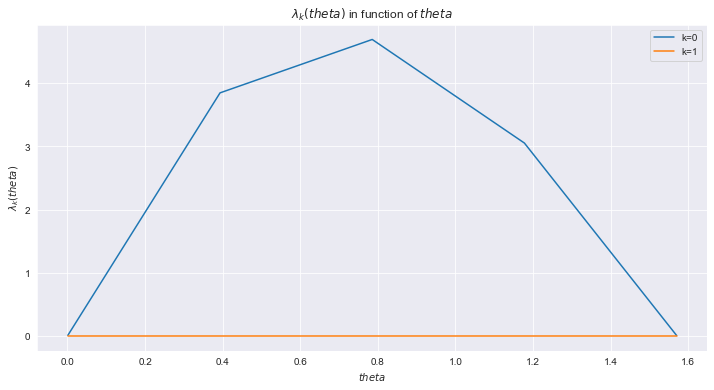

In [57]:
start = 1e-3
stop = np.pi/2 - 1e-3
num = 5
K = 1
ks = np.arange(0, K+1)

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
s = time.time()
ys = [[lambda_2(k, theta) for theta in thetas] for k in ks]
e = time.time()
print('Took {:.3f} minutes'.format((e - s) / 60))

figsize = (12, 6)
plt.figure(figsize=figsize)
for k in ks:
    plt.plot(thetas, ys[k], label='k={:,}'.format(k))

plt.title('$\lambda_k(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_k(\\theta)$')
plt.legend()
plt.show()

In [61]:
start = 1e-3
stop = np.pi/2 - 1e-3
num = 50
K = 5
ks = np.arange(0, 2*K+1, step=2)

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
s = time.time()
ys = [[lambda_2(k, theta) for theta in thetas] for k in ks]
e = time.time()
print('Took {:.3f} minutes'.format((e - s) / 60))

figsize = (12, 6)
plt.figure(figsize=figsize)
for k in ks:
    plt.plot(thetas, ys[k], label='k={:,}'.format(k))

plt.title('$\lambda_k(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_k(\\theta)$')
plt.legend()
plt.show()

/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-pa

Traceback (most recent call last):
  File "/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/3683004545.py", line 9, in <module>
    ys = [[lambda_2(k, theta) for theta in thetas] for k in ks]
  File "/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/3683004545.py", line 9, in <listcomp>
    ys = [[lambda_2(k, theta) for theta in thetas] for k in ks]
  File "/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/3683004545.py", line 9, in <listcomp>
    ys = [[lambda_2(k, theta) for theta in thetas] for k in ks]
  File "/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_16623/1329326521.py", line 6, in lambda_2
    return scipy.integrate.dblquad(
  File "/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-pa


KeyboardInterrupt



In [33]:
def odd_q_tilde(alpha, theta, mean=0, scale=1, sign=True, d_H=1):
    return scipy.integrate.quad(
        lambda r: (r ** d_H) * odd_q(r * alpha, theta) * np.exp(-(r ** 2)/2), a=0, b=np.inf)[0]

In [12]:
def velocity_1d(theta, u, f_H):
    return scipy.integrate.quad(
        lambda x_H: f_H(x_H) * q(u * x_H, theta) * np.exp(- (x_H ** 2) / 2) / np.sqrt(2 * np.pi),
        a=-np.inf,
        b=np.inf)[0]

In [14]:
def velocity_2d(theta, phi, f_H):
    return scipy.integrate.dblquad(
        lambda y,x: f_H(x,y) * q(np.cos(phi) * x + np.sin(phi) * y, theta) * np.exp(-(x**2 + y**2)/2) / (2*np.pi),
        a=-np.inf,
        b=np.inf, 
        gfun=-np.inf,
        hfun=np.inf
    )[0]

In [ ]:
import time
num = 20

start = time.time()
thetas = np.linspace(1e-6, np.pi/2, num=num)
[velocity_2d(theta, 0, f_H) for theta in thetas]
end = time.time()
print('Time spent on {:,} values : {:.3f} seconds'.format(num, end - start))

## 1D plots

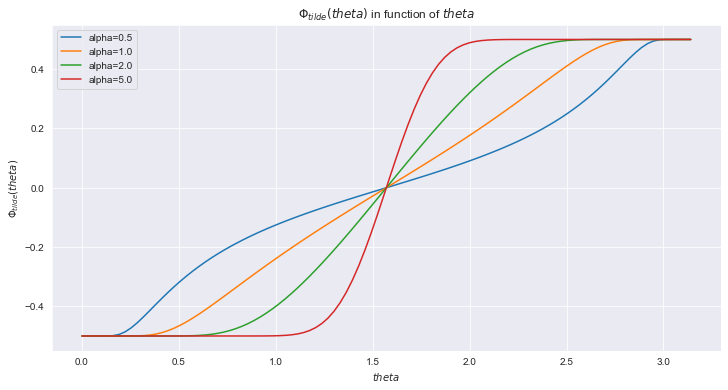

In [97]:
alphas = [0.5, 1.0, 2.0, 5.0]
start = 1e-3
stop = np.pi - 1e-3
num = 100

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [phi_tilde(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$\Phi_{tilde}(theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$\Phi_{tilde}(theta)$')
plt.legend()
plt.show()

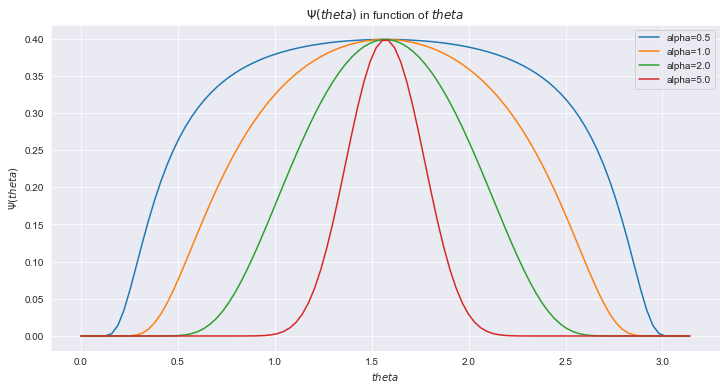

In [98]:
alphas = [0.5, 1.0, 2.0, 5.0]
start = 1e-3
stop = np.pi - 1e-3
num = 100

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [psi(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$\Psi(theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$\Psi(theta)$')
plt.legend()
plt.show()

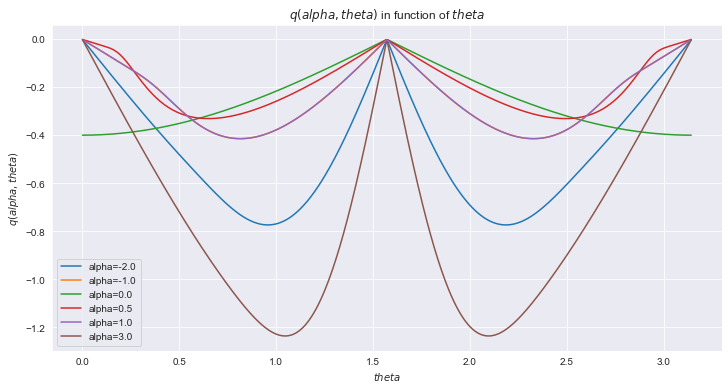

In [99]:
alphas = [-2.0, -1.0, 0., 0.5, 1.0, 3.0]
start = 1e-3
stop = np.pi - 1e-3
num = 500

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$q(alpha, theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

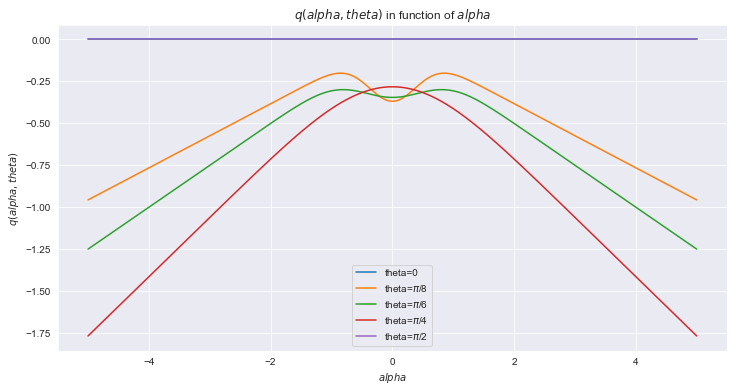

In [100]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, thetas[0], sign=False)] + [q(alphas, theta) for theta in thetas[1:]]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

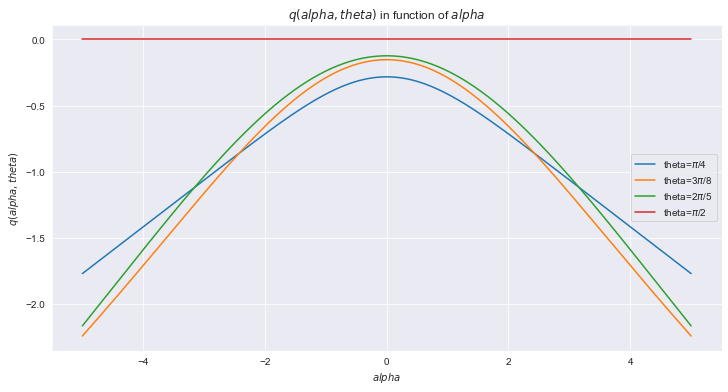

In [101]:
thetas = [np.pi/4, 3*np.pi/8, 2*np.pi/5, np.pi/2]
label_thetas = ['$\pi$/4', '3$\pi$/8', '2$\pi$/5', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, theta) for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

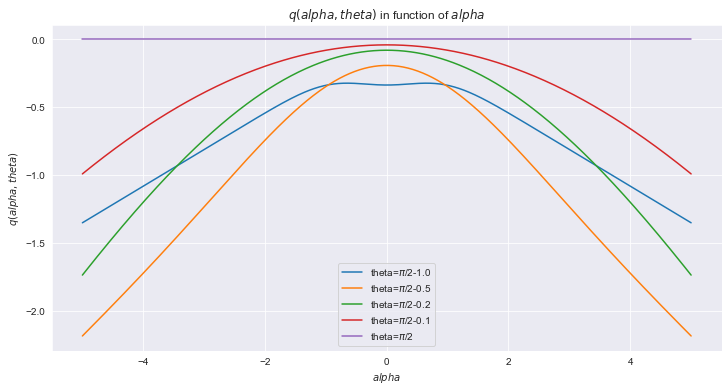

In [104]:
thetas = [np.pi/2 - 1.0, np.pi/2 - 0.5, np.pi/2 - 0.2, np.pi/2 - 0.1, np.pi/2]
label_thetas = ['$\pi$/2-1.0', '$\pi$/2-0.5', '$\pi$/2-0.2', '$\pi$/2-0.1', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, theta) for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

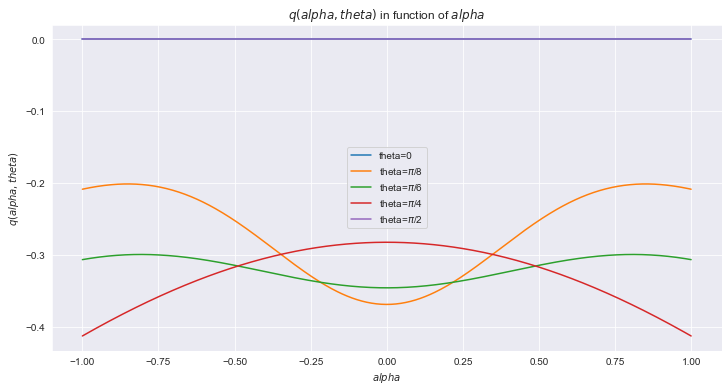

In [114]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -1.0
stop = 1.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, thetas[0], sign=False)] + [q(alphas, theta) for theta in thetas[1:]]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

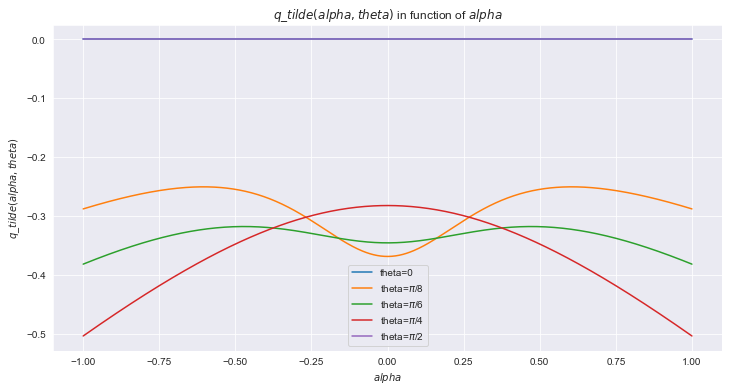

In [117]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -1.0
stop = 1.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[q_tilde(alpha, theta) for alpha in alphas] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q\_tilde(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q\_tilde(alpha, theta)$')
plt.legend()
plt.show()

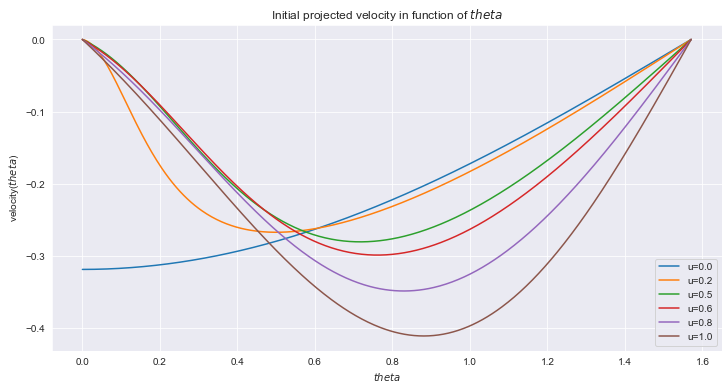

In [139]:
us = [0., 0.2, 0.5, 0.6, 0.8, 1.0]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

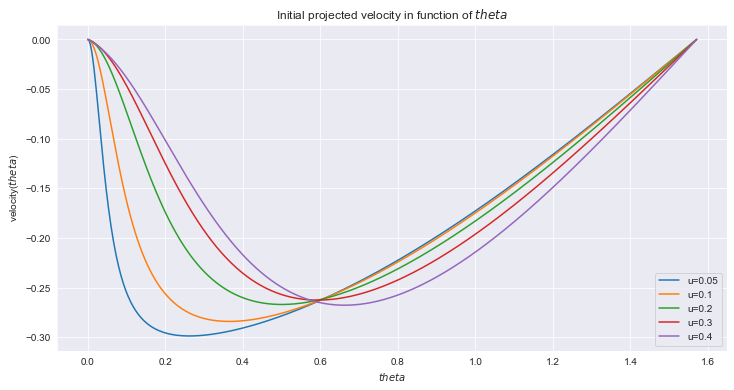

In [141]:
us = [0.05, 0.1, 0.2, 0.3, 0.4]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

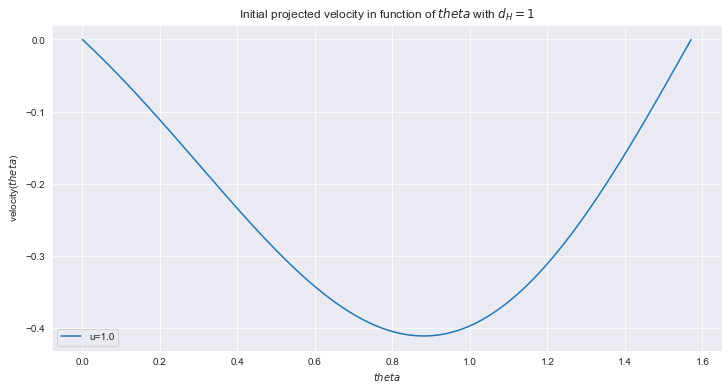

In [173]:
us = [1.0]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 1$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

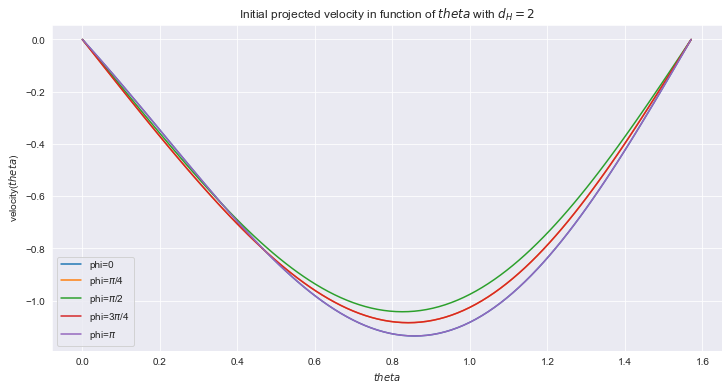

In [174]:
phis = [0., np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
label_phis = ['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$']
start = 1e-6
stop = np.pi/2
num = 100
a = 2
b = 1

f_H = lambda x,y: a * np.abs(x) + b * np.abs(y)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_2d(theta, phi, f_H) for theta in thetas] for phi in phis]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, phi in enumerate(phis):
    plt.plot(thetas, ys[i], label='phi={}'.format(label_phis[i]))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

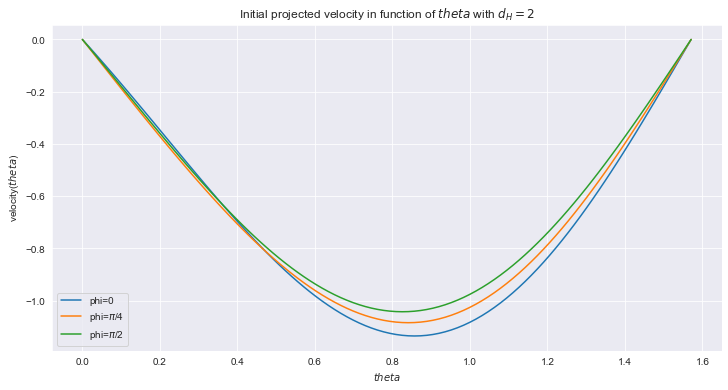

In [176]:
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, phi in enumerate(phis[:3]):
    plt.plot(thetas, ys[i], label='phi={}'.format(label_phis[i]))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

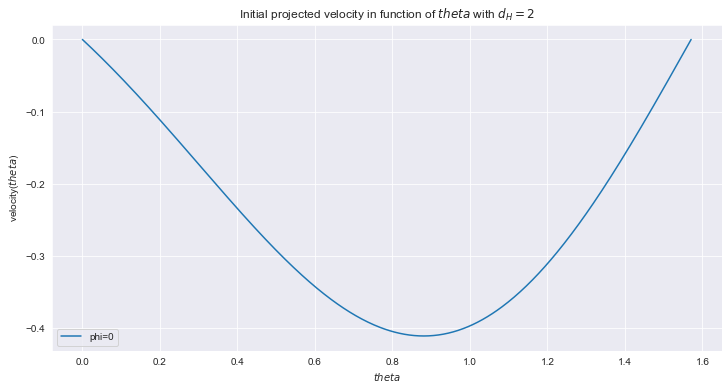

In [171]:
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(thetas, ys[0], label='phi={}'.format(0))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

## 2D plots

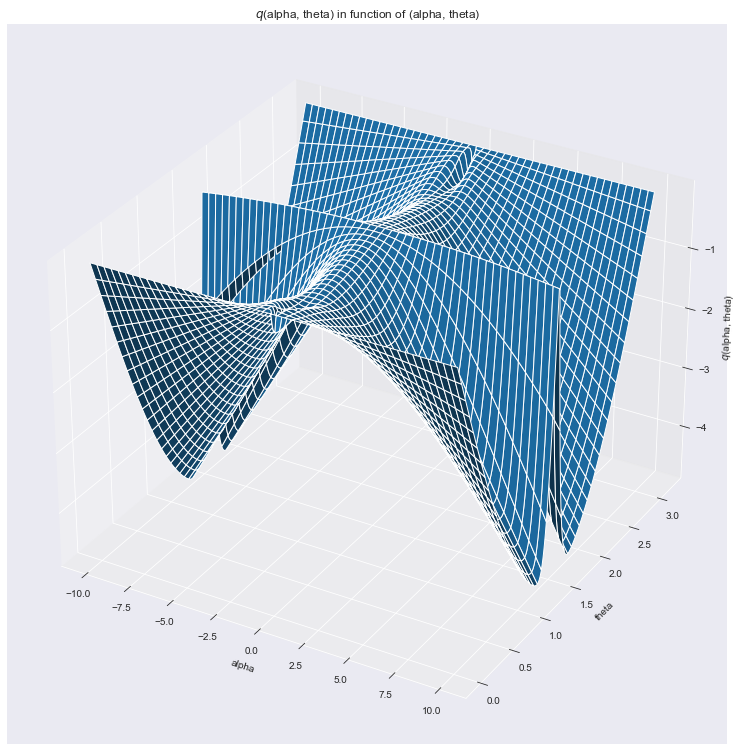

In [103]:
alphas = [0.5, 1.0, 2.0, 5.0]

start_alpha = -10.0
stop_alpha = 10.0

start_theta = 1e-3
stop_theta = np.pi - 1e-3
num = 300

alphas = np.linspace(start=start_alpha, stop=stop_alpha, endpoint=True, num=num)
thetas = np.linspace(start=start_theta, stop=stop_theta, endpoint=True, num=num)

X, Y = np.meshgrid(alphas, thetas)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        Z[i,j] = q(X[i,j], Y[i,j])

figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = Axes3D(fig, auto_add_to_figure=False)
ax.plot_surface(X, Y, Z)
fig.add_axes(ax)

plt.title('$q$(alpha, theta) in function of (alpha, theta)')

ax.set_xlabel('alpha')
ax.set_ylabel('theta')
ax.set_zlabel('$q$(alpha, theta)')
plt.show()

## Volumes of the unit ball and shere

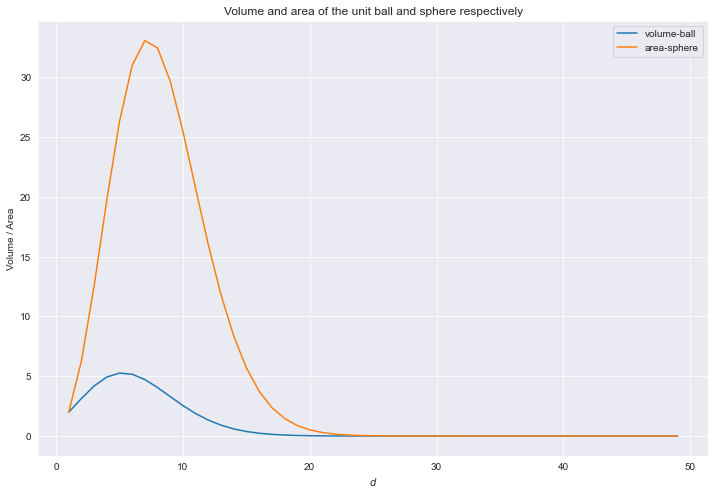

In [19]:
ds = np.arange(1, 50)
volumes = [(np.pi ** (d/2)) / scipy.special.gamma(d/2 + 1) for d in ds]
areas = [2 * (np.pi ** (d/2)) / scipy.special.gamma(d/2) for d in ds]
plt.figure(figsize=(12, 8))
plt.plot(ds, volumes, label='volume-ball')
plt.plot(ds, areas, label='area-sphere')

plt.legend()
plt.title('Volume and area of the unit ball and sphere respectively')
plt.xlabel('$d$')
plt.ylabel('Volume / Area')
plt.show()